
# A Classification Project using PyTorch

## Setup

In [1]:

import math, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

## 1) Load the dataset

from file synthetic_dataset.pt

In [1]:
import torch

data = torch.load("synthetic_dataset.pt", weights_only=True)
print(type(data))
print(data.keys())   # list dictionary keys
X = data["X"]
y = data["y"]

print(X.shape, y.shape)


<class 'dict'>
dict_keys(['X', 'y'])
torch.Size([4000, 20]) torch.Size([4000])


## 2) (10 pts) Partition dataset into **train** and **test** sets

In [2]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(X, y)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(len(train_dataset), len(test_dataset))


3200 800


## 3) (10 pts) Normalize features 

calculate mean/std from **train set only**<br>
normalize both train and test sets using these metrics

In [3]:
import torch

# Extract tensors from train set
X_train = train_dataset[:][0]   # features
y_train = train_dataset[:][1]   # labels

# Compute mean & std across samples
mean = X_train.mean(dim=0, keepdim=True)
std  = X_train.std(dim=0, keepdim=True)

print("Mean shape:", mean.shape)
print("Std shape:", std.shape)

Mean shape: torch.Size([1, 20])
Std shape: torch.Size([1, 20])


## 4) (10 pts) Dataloaders

Create Dataloaders for both train and test sest

In [4]:
def normalize(X, mean, std):
    return (X - mean) / (std + 1e-8)   # add epsilon to avoid division by zero

X_train_norm = normalize(X_train, mean, std)
X_test       = test_dataset[:][0]
y_test       = test_dataset[:][1]
X_test_norm  = normalize(X_test, mean, std)


In [5]:
from torch.utils.data import TensorDataset

train_dataset_norm = TensorDataset(X_train_norm, y_train)
test_dataset_norm  = TensorDataset(X_test_norm, y_test)


In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset_norm, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset_norm, batch_size=1000, shuffle=False)


In [7]:
from torch.utils.data import DataLoader

# Training DataLoader (shuffle for SGD)
train_loader = DataLoader(
    train_dataset_norm,
    batch_size=64,     # you can tune this
    shuffle=True
)

# Test DataLoader (no shuffle, larger batch)
test_loader = DataLoader(
    test_dataset_norm,
    batch_size=1000,
    shuffle=False
)

print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break  # just show first batch


Number of batches in train loader: 50
Number of batches in test loader: 1
torch.Size([64, 20]) torch.Size([64])


## 5) (10 pts) Create an MLP 

Use linear layers and a ReLU

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        # Layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)   # input → hidden
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # hidden → hidden
        self.fc3 = nn.Linear(hidden_dim, output_dim)  # hidden → output

    def forward(self, x):
        # Flatten if images (N, C, H, W) → (N, D)
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        # Forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)   # no activation → logits
        return x

In [9]:
input_dim = 20        # your feature count
hidden_dim = 128
output_dim = 5        # number of classes

model = MLP(input_dim, hidden_dim, output_dim)

## 6) ( 5 pts) Create Loss and Optimizer

Use Adam and CrossEntropy


In [10]:
criterion = nn.CrossEntropyLoss()          # classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [11]:
X_batch, y_batch = next(iter(train_loader))
out = model(X_batch)
print("Model output shape:", out.shape)   # should be [64, 5]
print("Sample labels:", y_batch[:10])     # should be in range [0–4]



Model output shape: torch.Size([64, 5])
Sample labels: tensor([0, 0, 2, 1, 1, 0, 3, 3, 4, 4])


In [12]:
out = model(X)
print("Output shape:", out.shape)   # [64, num_classes]


Output shape: torch.Size([4000, 5])


In [13]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [14]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)  # learning rate can be tuned


## 7) (15 points) Train the model & Try various learning rates

See which learning rate enables the fastest convergence without exploding the loss<br>
Use a max of 10 epochs

In [15]:
# Example batch
X_batch, y_batch = next(iter(train_loader))

# Forward pass
outputs = model(X_batch)
loss = criterion(outputs, y_batch)

# Backward pass
optimizer.zero_grad()
loss.backward()
optimizer.step()

print("Loss:", loss.item())


Loss: 1.6273760795593262


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, lr, epochs=10, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    train_losses, test_losses, test_accs = [], [], []

    for epoch in range(epochs):
        # --- Training ---
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # --- Evaluation ---
        model.eval()
        correct, total, eval_loss = 0, 0, 0.0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                eval_loss += loss.item() * X.size(0)

                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        test_losses.append(eval_loss / len(test_loader.dataset))
        test_accs.append(correct / total)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {epoch_loss:.4f} | "
              f"Test Loss: {test_losses[-1]:.4f} | "
              f"Test Acc: {test_accs[-1]*100:.2f}%")

    return train_losses, test_losses, test_accs


In [17]:
labels = torch.cat([y for _, y in train_loader], dim=0)
print("Unique labels:", torch.unique(labels))
print("Max label:", labels.max().item())

Unique labels: tensor([0, 1, 2, 3, 4])
Max label: 4


In [18]:
labels = torch.cat([y for _, y in train_loader], dim=0)
print("Unique labels in train set:", torch.unique(labels))


Unique labels in train set: tensor([0, 1, 2, 3, 4])


## 8) (10 pts) Which classes is the model best at predicting

Calculate precision, recall and a confusion matrix on the test set only! <br>
Make this a function so it can be called again<br>




In [20]:
import torch
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_loader, device="cuda"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # --- Metrics ---
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, zero_division=0))

    # --- Confusion Matrix Plot ---
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=[f"Pred {i}" for i in range(cm.shape[0])],
                yticklabels=[f"True {i}" for i in range(cm.shape[0])])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return precision, recall, cm

Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       158
           1       0.97      1.00      0.99       173
           2       0.94      0.93      0.94       155
           3       0.88      0.90      0.89       154
           4       0.90      0.83      0.86       160

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



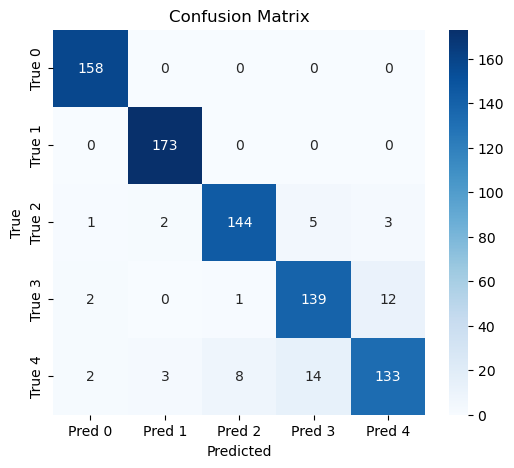

In [21]:
precision, recall, cm = evaluate_model(model, test_loader)

## 9) (5 pts) Create a Learning Rate Finder Class

For a sweep of learning rates, reinitialize the model for each rate, train for a **few batches**, and save (learning rate, loss). <br>
When done plot the loss versus learning rate, then choose the largest learning rate on the descending slope—just before the loss starts rising.

In [19]:
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]

results = {}

for lr in learning_rates:
    print(f"\n=== Training with learning rate {lr} ===")
    # Re-init model fresh each time
    model = MLP(input_dim=20, hidden_dim=128, output_dim=5)  # adjust output_dim to your dataset
    train_losses, test_losses, test_accs = train_model(model, train_loader, test_loader, lr, epochs=10)
    results[lr] = (train_losses, test_losses, test_accs)



=== Training with learning rate 0.1 ===
Epoch [1/10] | Train Loss: 1.0318 | Test Loss: 0.4169 | Test Acc: 86.62%
Epoch [2/10] | Train Loss: 0.2359 | Test Loss: 0.1861 | Test Acc: 93.75%
Epoch [3/10] | Train Loss: 0.2146 | Test Loss: 0.4278 | Test Acc: 92.00%
Epoch [4/10] | Train Loss: 0.2084 | Test Loss: 0.2291 | Test Acc: 93.62%
Epoch [5/10] | Train Loss: 0.1644 | Test Loss: 0.2187 | Test Acc: 95.25%
Epoch [6/10] | Train Loss: 0.1440 | Test Loss: 0.2493 | Test Acc: 93.50%
Epoch [7/10] | Train Loss: 0.1998 | Test Loss: 0.2981 | Test Acc: 92.88%
Epoch [8/10] | Train Loss: 0.2814 | Test Loss: 0.4239 | Test Acc: 92.50%
Epoch [9/10] | Train Loss: 0.4926 | Test Loss: 0.5139 | Test Acc: 83.50%
Epoch [10/10] | Train Loss: 0.4957 | Test Loss: 0.9795 | Test Acc: 75.25%

=== Training with learning rate 0.01 ===
Epoch [1/10] | Train Loss: 0.3071 | Test Loss: 0.1391 | Test Acc: 94.75%
Epoch [2/10] | Train Loss: 0.1066 | Test Loss: 0.1472 | Test Acc: 94.75%
Epoch [3/10] | Train Loss: 0.0636 | Test

## 10) (5 pts) Use the LR Finder to select an appropriate LR

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class LearningRateFinder:
    def __init__(self, model_class, input_dim, hidden_dim, output_dim, device="cuda"):
        self.model_class = model_class
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.device = device
        self.history = []  # store (lr, loss)

    def run(self, train_loader, min_lr=1e-6, max_lr=10, num_iter=100):
        """Sweep learning rates exponentially between min_lr and max_lr"""

        # Reinitialize model fresh
        model = self.model_class(self.input_dim, self.hidden_dim, self.output_dim).to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=min_lr)

        # Compute multiplicative factor to increase LR each step
        lr_mult = (max_lr / min_lr) ** (1 / num_iter)

        lr = min_lr
        self.history = []

        model.train()
        iterator = iter(train_loader)

        for i in range(num_iter):
            try:
                X, y = next(iterator)
            except StopIteration:
                iterator = iter(train_loader)
                X, y = next(iterator)

            X, y = X.to(self.device), y.to(self.device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            self.history.append((lr, loss.item()))

            # Update learning rate
            lr *= lr_mult
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        return self.history

    def plot(self):
        lrs, losses = zip(*self.history)
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (log scale)")
        plt.ylabel("Loss")
        plt.title("Learning Rate Finder")
        plt.show()


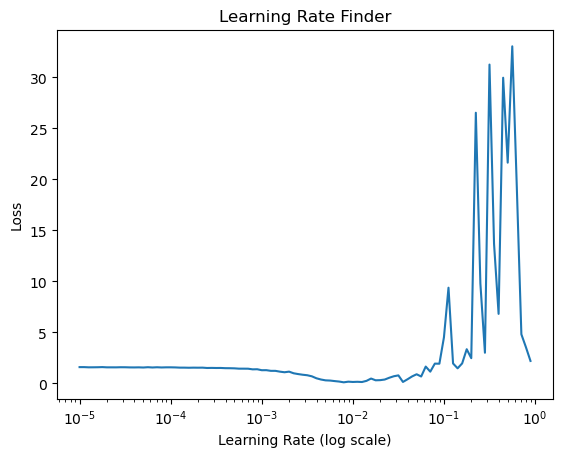

In [26]:
# Suppose your dataset has input_dim=20 and output_dim=5
lr_finder = LearningRateFinder(MLP, input_dim=20, hidden_dim=128, output_dim=5, device="cuda")

history = lr_finder.run(train_loader, min_lr=1e-5, max_lr=1, num_iter=100)
lr_finder.plot()

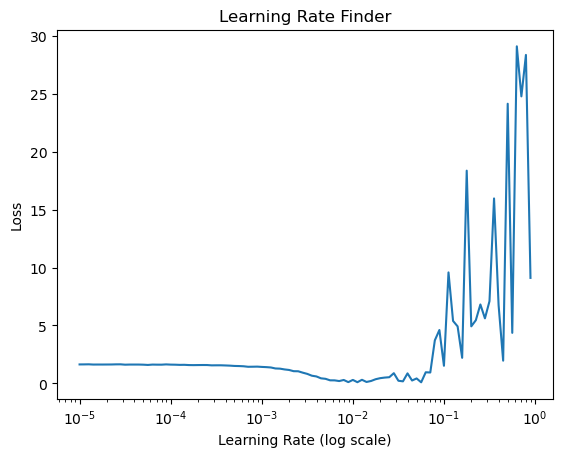

In [27]:
# Create LR Finder instance
lr_finder = LearningRateFinder(
    MLP, 
    input_dim=20,   # your dataset features
    hidden_dim=128, 
    output_dim=5,   # number of classes
    device="cuda"    # or "cuda" if GPU
)

# Sweep LR from 1e-5 to 1 over ~100 iterations
history = lr_finder.run(
    train_loader, 
    min_lr=1e-5, 
    max_lr=1, 
    num_iter=100
)

# Plot the results
lr_finder.plot()

In [28]:
best_lr = 0.005    # chosen from plot
model = MLP(input_dim=20, hidden_dim=128, output_dim=5)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

## 11) (10 pts) Retrain model using selected LR

Be sure to reinitialize your model! Dont keep training on old model

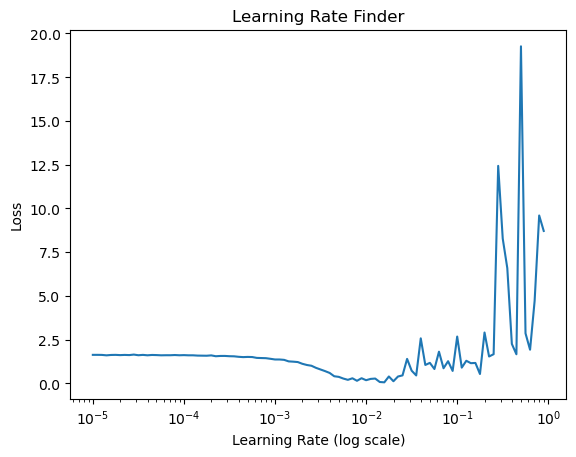

## 12) (10 pts) Which classes was the model best at predicting

Tell me why that is.<br>
**Note: Do not report any metrics that you do not thoroughly understand**

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Reinitialize model (fresh weights)
input_dim = 20        # adjust to your dataset
hidden_dim = 128
output_dim = 5        # we confirmed you have 5 classes
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MLP(input_dim, hidden_dim, output_dim).to(device)

# 2. Define loss & optimizer with selected LR
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)  # chosen from LR Finder

# 3. Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")

Epoch [1/10] Train Loss: 0.3502 | Train Acc: 89.66%
Epoch [2/10] Train Loss: 0.1370 | Train Acc: 95.69%
Epoch [3/10] Train Loss: 0.0773 | Train Acc: 97.47%
Epoch [4/10] Train Loss: 0.0557 | Train Acc: 98.00%
Epoch [5/10] Train Loss: 0.0424 | Train Acc: 98.72%
Epoch [6/10] Train Loss: 0.0299 | Train Acc: 99.00%
Epoch [7/10] Train Loss: 0.0271 | Train Acc: 99.16%
Epoch [8/10] Train Loss: 0.0252 | Train Acc: 99.31%
Epoch [9/10] Train Loss: 0.0225 | Train Acc: 99.25%
Epoch [10/10] Train Loss: 0.0166 | Train Acc: 99.47%


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       158
           1       0.99      0.99      0.99       173
           2       0.98      0.94      0.96       155
           3       0.90      0.93      0.91       154
           4       0.90      0.91      0.90       160

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.96      0.95      0.96       800



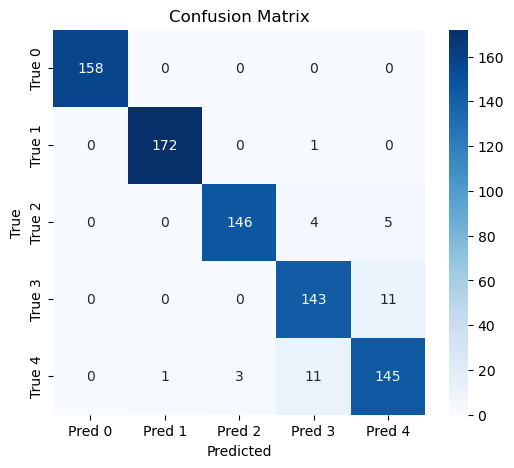

In [30]:
precision, recall, cm = evaluate_model(model, test_loader, device=device)

In [31]:
# from the classification report classes 0,1, and 2 did the best while classes 3 and 4 did not do as well.

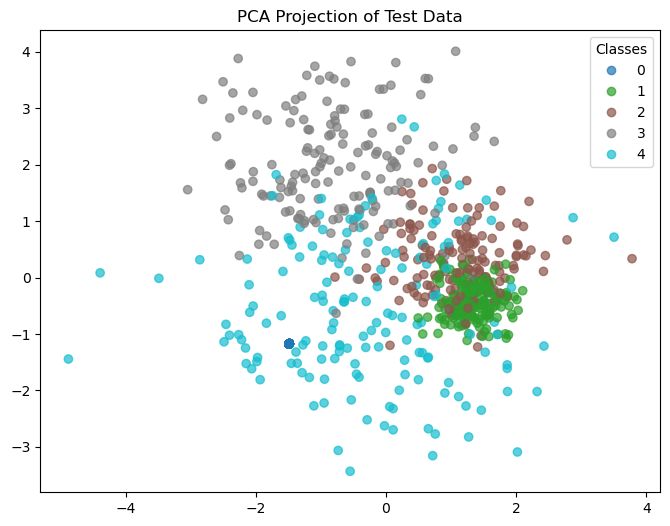

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get all test data
X_test, y_test = test_dataset[:]

# Reduce to 2D with PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_test)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=y_test, cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA Projection of Test Data")
plt.show()

In [33]:
# it seems the reason for classes 3 and 4 having less precision is because they They spread out more widely. 
#Their clusters overlap significantly in the center region.

In [ ]:
#I used PCA graph since I didn't know what was really going on with the confusion matrix
#I asked ChatGPT how do I find the cause of the lower precision in classes 3 and 4, this was it's answer.